## Inicialization

In [1]:
# Importar las librerias necesarias
import pandas as pd
import numpy as np
import re
from scipy import stats as st
from matplotlib import pyplot as plt
import seaborn as sns
import math as mt
from math import factorial

## Load data

In [2]:
# Extraer los datos del dataset.
games_df = pd.read_csv('../data/games.csv')

- El dataframe cargado contiene informacion sobre la venta de videojuegos en distintos paises.

## Preparar los datos

### Ver la estructura de los datos

In [3]:
# Revisar la estructura de la tabla
games_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


#### Observaciones: 
- En la tabla se observa la siguiente informacion sobre cada videojuego:

— `'Name'`: Nombre 
— `'Platform'`: Plataforma

— `'Year_of_Release'`: Año de lanzamiento

— `'Genre'`: Género

— `'NA_sales'`: ventas en Norteamérica en millones de dólares estadounidenses

— `'EU_sales'`: ventas en Europa en millones de dólares estadounidenses

— `'JP_sales'`: ventas en Japón en millones de dólares estadounidenses

— `'Other_sales'`: ventas en otros países en millones de dólares estadounidenses

— `'Critic_Score'`: Reseña de los críticos, máximo de 100 

— `'User_Score'`: Reseña de los usuarios, máximo de 10 

— `'Rating'`: Clasificacion ESRB, según el contenido de un juego y asigna una clasificación de edad como Adolescente o Adulto.

In [4]:
# Revisar los datos
games_df.sample(3)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
14245,Detective Conan: Phantom Rhapsody,3DS,2014.0,Action,0.00,0.00,0.03,0.0,NaN,NaN,NaN
12948,Jirou Akagawa: Majotachi no Nemuri,SNES,1995.0,Adventure,0.00,0.00,0.05,0.0,NaN,NaN,NaN
10272,The Polar Express,GC,2004.0,Adventure,0.08,0.02,0.00,0.0,40.0,4.7,E


In [5]:
# Cambiar los nombres de las columnas a minusculas
games_df.columns = games_df.columns.str.strip().str.lower()

### Valores nulos

In [6]:
# Verificar donde se encuentran valores nulos
games_df.isna().sum()

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         6701
rating             6766
dtype: int64

Se observa un par de filas con valores ausentes en `name` y `genre`, no tiene sentido llevar un regitro de un juego si no conocemos el nombre de este, por lo que es conveniente eliminar los registros con valores ausentes en esa columna.
Tambien hay varios datos nulos en la columna `year_of_release`.
Existe una cantidad considerable de filas con valores ausentes en `critic_score`, `user_score` y `rating`

In [7]:
# Elimina los registros con valores ausentes en la columna 'name'
games_df = games_df[~games_df['name'].isna()]

In [8]:
# Muestra las filas sin informacion en 'year_of_release'
print(games_df[games_df['year_of_release'].isna()]['name'])

183                        Madden NFL 2004
377                       FIFA Soccer 2004
456             LEGO Batman: The Videogame
475             wwe Smackdown vs. Raw 2006
609                         Space Invaders
                       ...                
16373    PDC World Championship Darts 2008
16405                        Freaky Flyers
16448                            Inversion
16458          Hakuouki: Shinsengumi Kitan
16522                         Virtua Quest
Name: name, Length: 269, dtype: object


Se puede observar que algunos de los juegos con valores nulos en la columna `year_of_release` contienen la informacion del año de lanzamiento en la columna `name`. Intentaremos rescatar esos datos, ya que el año de lanzamiento es informacion clave para nuesto análisis

In [9]:
def extract_year_from_name(name):
    # Buscar un patrón de 4 dígitos en el nombre del juego
    match = re.search(r'\b(19|20)\d{2}\b', name)
    if match:
        return int(match.group(0))
    return None

In [10]:
# Rellenar los valores nulos en 'year_of_release' usando el año extraído del nombre del juego
games_df['year_of_release'] = games_df.apply(
    lambda row: extract_year_from_name(row['name']) if pd.isnull(row['year_of_release']) else row['year_of_release'],
    axis=1
)

In [11]:
# Verifica la cantidad de datos nulos en 'year_of_release'
games_df['year_of_release'].isna().sum()

np.int64(252)

Aún queda 252 filas sin informacion en la columna `year_of_release` y no parece correcto asignarles las medidas medias o la mediana, ni tampoco eliminarlas. Por lo que será mejor llenar los valores restantes con 0 e ignorar estos datos para los analisis que requieran puntualmente esa columna. Lo mismo aplica para los valores ausentes en `critic_score` y `user_score`.

In [12]:
# Llena los valores ausentes con 0 en la columna 'year_of_release'
games_df['year_of_release'].fillna(0,inplace= True)

C:\Users\Molix.x\AppData\Local\Temp\ipykernel_14616\3546511231.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  games_df['year_of_release'].fillna(0,inplace= True)


In [13]:
# Verifica datos ausentes en la columna 'rating'
games_df[games_df['rating'].isna()].head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN
10,Nintendogs,DS,2005.0,Simulation,9.05,10.95,1.93,2.74,NaN,NaN,NaN


Las filas con valores ausentes en `'rating'` tambien tienen valores ausentes en las columnas `'user_score'` y `'critic_score'` por lo que se podria concluir que sin la clasificación ESRB no lo puntuan ni los usuarios ni los criticos, o no se lleva el registro de estos datos.
Por otro lado tambien hay registos en los que solo esá ausente el `'critic_score'`.

In [14]:
# Cuenta cuantos de los valores ausentes NO concuerdan con la hipotesis anterior
games_df[(games_df['critic_score'].isna())&(~games_df['rating'].isna())]['rating'].count()

np.int64(1895)

Existen 1895 registros que tienen algun valor en  `'rating'` y no en `'critic_score'` cuyas causas de valores nulos son desconocidas

In [15]:
games_df.fillna(0, inplace= True)

### Duplicados
Un mismo videojuego puede estar disponible para varias plataformas y del mismo modo ser lanzado en años diferentes para cada una, o incluso ser una version remasterizada, por lo que se considera duplicado solo si se repiten los datos en estas 3 columnas: `'name','platform','year_of_release'`.

In [16]:
games_df[games_df[['name','platform','year_of_release']].duplicated()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
16230,Madden NFL 13,PS3,2012.0,Sports,0.0,0.01,0.0,0.0,83.0,5.5,E


Se encontró solo un valor duplicado

In [17]:
Madden_Nfl_13 = games_df[games_df['name']=='Madden NFL 13']
Madden_Nfl_13

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
507,Madden NFL 13,X360,2012.0,Sports,2.53,0.15,0.0,0.17,81.0,5.8,E
604,Madden NFL 13,PS3,2012.0,Sports,2.11,0.22,0.0,0.23,83.0,5.5,E
3986,Madden NFL 13,Wii,2012.0,Sports,0.47,0.00,0.0,0.03,0.0,7.3,E
5887,Madden NFL 13,PSV,2012.0,Sports,0.28,0.00,0.0,0.02,63.0,7.3,E
7066,Madden NFL 13,WiiU,2012.0,Sports,0.21,0.00,0.0,0.02,75.0,6.7,E
16230,Madden NFL 13,PS3,2012.0,Sports,0.00,0.01,0.0,0.00,83.0,5.5,E


Se puede ver que se repite el nombre del juego varias veces pero solo la fila para PS3 está duplicada, el segundo registro solo contiene ventas en Europa y los otros datos son exactaemnte igual por lo que será bueno fusionar las filas, antes de eliminar el duplicado.

In [18]:
# Suma las ventas en europa de ambos registros
eu_sales= Madden_Nfl_13[Madden_Nfl_13['platform']=='PS3']['eu_sales'].sum()

In [19]:
# Asigna la suma de las ventas en europa al registro original que conservaremos
games_df.loc[604,'eu_sales']= eu_sales

In [20]:
# Elimina el registro duplicado
games_df = games_df.drop_duplicates(subset=['name', 'platform', 'year_of_release'])
games_df[['name','platform','year_of_release']].duplicated().sum()

np.int64(0)

In [21]:
# Suma las ventas totales de cada videojuego
games_df['total_sales'] = games_df['na_sales'] + games_df['eu_sales'] + games_df['jp_sales'] + games_df['other_sales']

In [22]:
games_df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E,82.54
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,0.0,0,0,40.24
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,0.0,0,0,31.38


In [23]:
# Busca duplicados parciales en la columna 'platform'
games_df['platform'].unique()

array(['Wii', 'NES', 'GB', 'DS', 'X360', 'PS3', 'PS2', 'SNES', 'GBA',
       'PS4', '3DS', 'N64', 'PS', 'XB', 'PC', '2600', 'PSP', 'XOne',
       'WiiU', 'GC', 'GEN', 'DC', 'PSV', 'SAT', 'SCD', 'WS', 'NG', 'TG16',
       '3DO', 'GG', 'PCFX'], dtype=object)

### Tipos de datos
La columna `year_of_release` contiene el año de lanzamiento del videojuego. Es mejor manejar los años como enteros para no generar errores. Sería extraño ver datos como año 2015.6 o similar

In [24]:
# Cambia el tipo de dato a 'year_of_release'
games_df['year_of_release'] = pd.to_numeric(games_df['year_of_release'])

La columna `'user_score'` no se puede analizar como `object` ya que este tipo de dato no permitiria realizar calculos aritmeticos por lo que seria mejor manejar estos datos como `float` 

In [25]:
games_df['user_score']= pd.to_numeric(games_df['user_score'], errors='coerce')


<div class="alert alert-block alert-warning">
<b>Comentario del revisor</b> <a class="tocSkip"></a>

Es verdad, en casos como estos se puede crear una segunda columna que sea numérica y que tenga valores nulos en donde debería ser tbd o completar con otro valor como la mediana.
</div>

In [26]:
# Crea una copia del data frame original con los datos 'user_score' filtrados
filtered_df = games_df[games_df['user_score'].notnull()].copy()
# Filtra los datos para ingnorar las filas con 'user_score' y/o 'critic_score' 0
filtered_df = filtered_df[(filtered_df['user_score']!=0)&(filtered_df['critic_score']!=0)]

In [27]:
# Filtra datos ingnorando las filas sin informacion en 'rating'
games_filtered_rating = games_df[games_df['rating']!=0]

In [28]:
# Filtra datos ingnorando las filas sin informacion en 'year_of_release'
games_year_filtered = games_df[games_df['year_of_release']!=0]

## Análisis de datos
### Juegos lanzados por año

In [29]:
# Agrupa los videojuegos por año de lanzamiento y contarlos
release_per_year = games_year_filtered.groupby('year_of_release')['name'].count()
#release_per_year

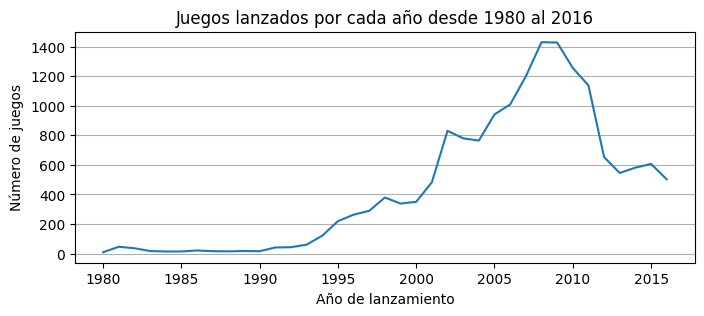

In [30]:
# Crea un gráfico con la cantidad de juegos lanzados cada año
release_per_year.plot(figsize=(8, 3))
plt.title('Juegos lanzados por cada año desde 1980 al 2016')
plt.xlabel('Año de lanzamiento')
plt.grid(axis= 'y')
plt.ylabel('Número de juegos')
plt.show()

#### Observaciones
Desde la década de los 80 hasta 1993, los lanzamientos anuales de videojuegos fueron relativamente bajos, fluctuando entre 9 y 60 títulos por año. Fue en 1994 cuando se superó por primera vez la barrera de los 100 lanzamientos anuales, iniciando así un crecimiento exponencial que se mantuvo de manera casi constante hasta 2009, año en que se lanzaron alrededor de 1400 videojuegos. Este período marcó el apogeo de la industria de los videojuegos.

Sin embargo, a partir de 2009, se observa un descenso significativo en la cantidad de lanzamientos anuales, hasta estabilizarse en los años posteriores en torno a los 600 juegos. Este cambio puede estar relacionado con diversas dinámicas en la industria, como la aparición de nuevas plataformas, cambios en los modelos de negocio, o un ajuste en la oferta de videojuegos.

#### Conclusiones 
La década de los 2000 fue un período de auge para la venta de videojuegos. El éxito en las ventas durante este periodo se debió probablemente al constante desarrollo y evolución de las consolas, así como a la intensa competencia entre las principales empresas desarrolladoras de estas plataformas. Sony, Microsoft y Nintendo fueron las compañías que lideraron el mercado con sus consolas más populares en esta época.

### Comparacion de ventas por plataformas 

In [31]:
# Crea una tabla dinamica para observar la variacion las ventas por plataforma a lo largo del tiempo.
sales_platform_year= games_year_filtered.pivot_table(index = 'year_of_release', 
                          columns ='platform', 
                          values = 'total_sales', 
                          aggfunc= 'sum')
sales_platform_year.tail()

platform,2600,3DO,3DS,DC,DS,GB,GBA,GC,GEN,GG,...,SAT,SCD,SNES,TG16,WS,Wii,WiiU,X360,XB,XOne
year_of_release,,,,,,,,,,,,,,,,,,,,,
2012.0,NaN,NaN,51.36,NaN,11.01,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,21.71,17.56,99.74,NaN,NaN
2013.0,NaN,NaN,56.57,NaN,1.54,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,8.59,21.65,88.58,NaN,18.96
2014.0,NaN,NaN,43.76,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,3.75,22.03,34.74,NaN,54.07
2015.0,NaN,NaN,27.78,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.14,16.35,11.96,NaN,60.14
2016.0,NaN,NaN,15.14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.18,4.60,1.52,NaN,26.15


In [32]:
# Crea una tabla dinamica para observar la variacion las ventas por plataforma a lo largo del tiempo.
sales_platform_lasts_years = games_year_filtered[games_year_filtered['year_of_release']>1999].pivot_table(index = 'year_of_release', 
                          columns ='platform', 
                          values = 'total_sales', 
                          aggfunc= 'sum')
# Obtiene las 5 plataformas con mayor cantidad de ventas a nivel historico
top_platforms = sales_platform_lasts_years.sum().sort_values(ascending=False).head(6)
top_platforms

platform
PS2     1247.28
X360     961.30
PS3      931.34
Wii      891.18
DS       802.77
PS4      314.14
dtype: float64

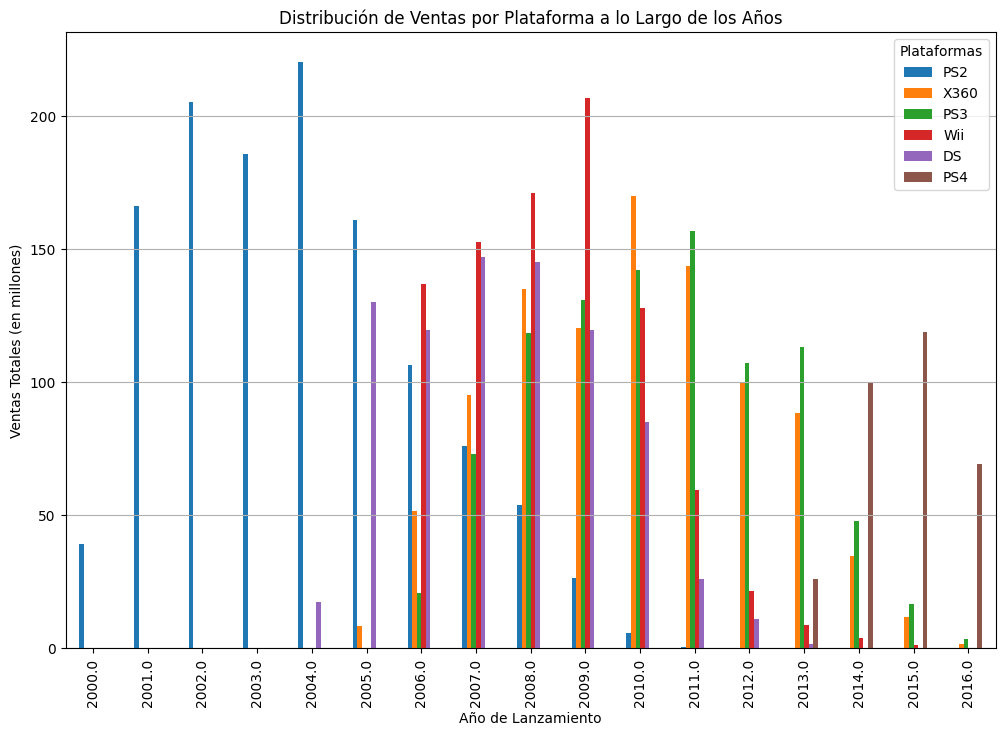

In [33]:
# Graficar las plataformas con mayores ventas
sales_platform_lasts_years[top_platforms.index].plot(figsize=(12, 8), kind='bar')
plt.title('Distribución de Ventas por Plataforma a lo Largo de los Años')
plt.xlabel('Año de Lanzamiento')
plt.legend(title='Plataformas')
plt.ylabel('Ventas Totales (en millones)')
plt.grid(axis= 'y')
plt.show()

#### Observaciones:
Entre 2000 y 2004, la PS2 dominó el mercado sin apenas competencia, comenzando con casi 50 millones de dólares en ventas en su primer año y alcanzando los 150 millones en 2001. En 2002, superó los 200 millones, y aunque en 2003 las ventas disminuyeron ligeramente, todavía se mantuvieron cerca de ese nivel.

En 2004, la Nintendo DS apareció en escena, pero no se convirtió en una verdadera competencia hasta 2005, año en que las ventas de la PS2 disminuyeron en más de 50 millones de dólares, mientras que la DS alcanzó casi 150 millones en ventas. También en 2005, Microsoft lanzó la Xbox 360, aunque sus ventas iniciales fueron modestas.

En 2006, las ventas de la PS2 seguían siendo fuertes, superando los 100 millones de dólares, pero Sony lanzó la PS3 y Nintendo la Wii, con esta última registrando ventas significativamente mayores, casi alcanzando los 150 millones en su primer año.

Con el tiempo, las ventas de la PS2 comenzaron a disminuir, desapareciendo por completo en 2012. La Xbox 360 experimentó altibajos entre 2008 y 2010, sin superar los 175 millones en ventas, y a partir de 2011, sus ventas comenzaron a disminuir de manera constante.

La PS3, por su parte, disfrutó de cinco años consecutivos de crecimiento en ventas, pero sufrió una caída significativa en 2012. Aunque hubo un ligero repunte en 2013, las ventas continuaron disminuyendo hasta desaparecer gradualmente, probablemente debido a la aparición de la PS4 como su sucesora.

Por otro lado, la PS4 parece liderar en ventas en los últimos años, sin competencia aparente al menos hasta la fecha en que se recopilaron los datos.

En cuanto a la Nintendo DS, sus ventas fluctuaron entre 100 y 150 millones de dólares entre 2006 y 2009, pero a partir de 2010, comenzaron a caer drásticamente, desapareciendo por completo en 2014.

La Wii de Nintendo tuvo un éxito considerable, superando a la DS. Desde su lanzamiento en 2006 hasta 2009, sus ventas aumentaron consistentemente, superando la barrera de los 200 millones de dólares. Sin embargo, en el año siguiente, sus ventas cayeron en casi 100 millones, y continuaron disminuyendo rápidamente hasta su desaparición en 2016.


#### Conclusiones
La década de 2000 fue una época dorada para la venta de videojuegos, con la PS2 aprovechando al máximo su dominio en el mercado, registrando las ventas más altas. Las ventas más altas de las consolas se registran generalmente entre los 5 y 6 años después de su lanzamiento, tras lo cual las ventas comienzan a disminuir. En promedio, una consola se mantiene vigente o popular entre 10 y 12 años antes de que se lance un nuevo modelo.
También se puede observar una disminución significativa en las ventas de todas las plataformas a partir de 2012. Desde entonces, y hasta 2016, ninguna plataforma volvió a superar los 150 millones en ventas.

### Ventas globales de los juegos por plataforma

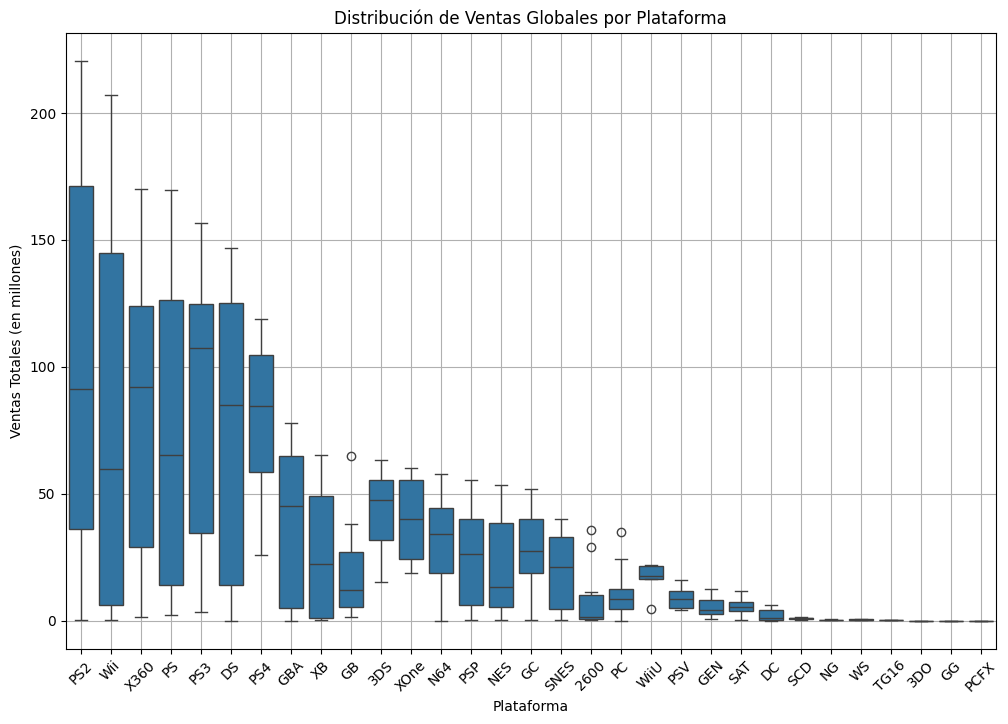

In [34]:
# Reformatear a formato largo para usar en un boxplot
sales_long = sales_platform_year.melt(var_name='Platform', value_name='Total Sales').sort_values('Total Sales', ascending= False)
sales_long = sales_long.dropna()
# Generar el diagrama de caja
plt.figure(figsize=(12, 8))
sns.boxplot(x='Platform', y='Total Sales', data=sales_long)
plt.title('Distribución de Ventas Globales por Plataforma')
plt.ylabel('Ventas Totales (en millones)')
plt.xlabel('Plataforma')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


#### Observaciones
Las diferencias en las ventas entre plataformas son notables. Las consolas se agrupan en cuatro categorías según su volumen de ventas, con una clara disparidad entre las más exitosas y las menos populares.

Grupo 1: Plataformas como SCD, NG, WS, TG16, 3DO, GG y PCFX registraron ventas muy bajas, aparentemente sin llegar siquiera al millón de dólares.

Grupo 2: En el segundo grupo se encuentran plataformas como 2600, PC, WiiU, PSVita, GEN, SAT y DC, cuyas ventas son mayores que las del Grupo 1, pero apenas superan los 25 millones de dólares.

Grupo 3: El tercer grupo incluye consolas como GBA, XB, GB, 3DS, XboxOne, Nintendo64, PSP, NES, GC y SNES, cuyas ventas oscilan entre los 25 y 50 millones de dólares. Destaca el GBA, que registra ventas superiores a los 50 millones y se acerca a los 75 millones.

Grupo 4: El cuarto grupo incluye las consolas con la mayor dispersión y volumen de ventas: PS2, Wii, Xbox360, PS, PS3, DS, y PS4. PS4 y Wii fueron las únicas en superar los 200 millones en ventas, mientras que PS, Xbox360 y PS3 superaron los 150 millones. Nintendo DS también destaca con ventas consistentemente por encima de los 100 millones.

Si bien el gráfico no muestra explícitamente los años de lanzamiento de los videojuegos o las plataformas, es posible deducir cuáles son las consolas más actuales, como XboxOne, 3DS, WiiU y PS4, dado que presentan valores mínimos de ventas más elevados. Esto sugiere que, según el análisis anterior, estas consolas podrían seguir registrando ventas en los próximos años.

#### Conclusion
Las ventas promedio varían significativamente entre las diferentes categorías. Las plataformas del Grupo 4, como PS2 y Wii, dominan con las mayores ventas promedio, mientras que las plataformas de los Grupos 1 y 2 tienen ventas mucho más modestas.

### Correlacion entre reseñas y ventas

In [35]:
# Filtra los datos para la plataforma elegida (PlayStation 3 en este caso)
platform_df = filtered_df[filtered_df['platform']=='PS3'][['total_sales','user_score','critic_score']]

In [36]:
# Calcula la correlación entre las reseñas y las ventas
corr_mat = platform_df.corr()
correlation_reviews_sales = corr_mat.loc['total_sales',['user_score','critic_score']]
correlation_reviews_sales

user_score      0.142657
critic_score    0.428835
Name: total_sales, dtype: float64

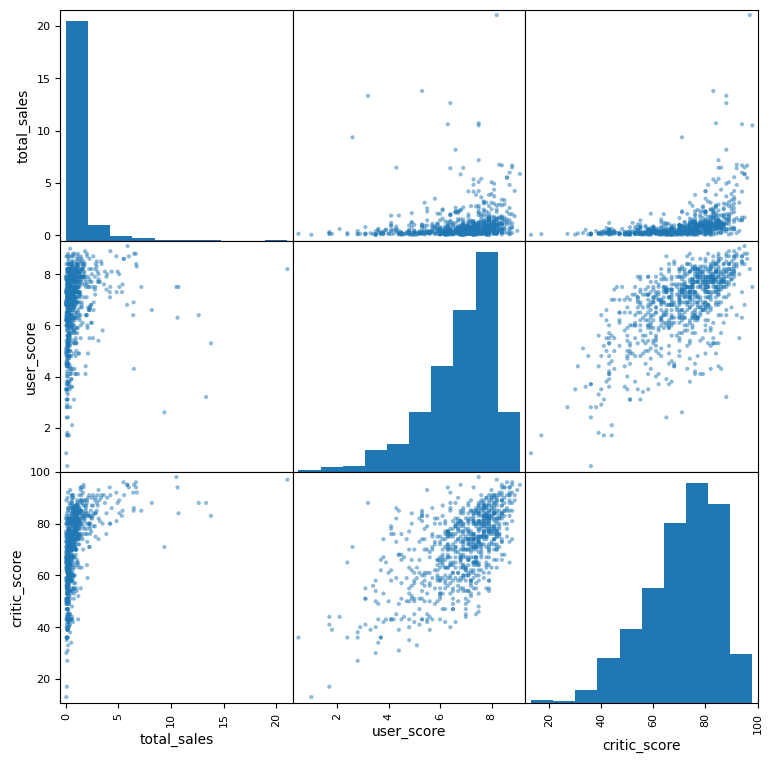

In [37]:
# Crea una matriz de correlacion entre las reseñas y las ventas
pd.plotting.scatter_matrix(platform_df, figsize=(9, 9))
plt.show()

#### Observaciones 
El gráfico anteriror es una matriz de dispersión que muestra las relaciones entre tres variables: `total_sales`, `user_score` y `critic_score`. Esta matriz incluye tanto gráficos de dispersión entre pares de variables como histogramas que muestran la distribución de cada variable de forma individual.

En la parte inferior derecha del gráfico, vemos la relación entre `user_score` y `critic_score`. Existe una relación positiva visible: cuando la puntuación de los usuarios (`user_score`) es alta, la puntuación de los críticos (`critic_score`) también tiende a ser alta. Esto sugiere que ambos tipos de puntajes tienden a estar de acuerdo, aunque la correlación no es perfecta. Esto puede ser indicativo de que, si bien los usuarios y críticos generalmente coinciden, hay diferencias notables en algunos casos.

En la primera columna, vemos la relación entre `total_sales` y las otras dos variables.
Entre `total_sales` y `user_score`, parece haber una débil correlación positiva, aunque no es muy fuerte. Hay una tendencia general a que juegos con mejores reseñas de usuarios tengan mayores ventas, pero también hay muchos casos donde juegos con buenas reseñas no alcanzan grandes ventas, o juegos con ventas masivas tienen puntuaciones promedio.
Entre `total_sales` y `critic_score`, la relación parece ser aún más débil. Aunque algunos juegos con altas ventas tienen buenos puntajes de crítica, hay una gran dispersión de datos, indicando que muchos juegos con bajas críticas también pueden tener altas ventas (y viceversa).

#### Conclusion
El exito o fracaso en las ventas de los videojuegos no depende al 100% de la reseña de los criticos o de los usuarios pero si se ve afectada en ocaciones por este factor. A su vez aunque los usuarios no siempre concuerdan con la opinion de los citicos parece haber cierta correlacion positiva, es decir opinan similar pero no igual.

### Comparacion de  ventas de videojuegos en otras plataformas.

Como se aprecia en el gráfico anterior, el volumen de datos es muy grande, por lo que se filtrarán para su análisis solo los juegos más vendidos en las plataformas con mayor popularidad en los últimos años.

In [38]:
# Filtra las plataformas competidoras de PS3
platform_ls = ['Wii', 'X360','PS3']
compare_games = filtered_df[filtered_df['platform'].isin(platform_ls)]

In [39]:
# Filtra los juegos disponibles en PS3
ps3_games  = filtered_df[filtered_df['platform']=='PS3']['name'].unique()

# Busca los mismos videojuegos disponibles en otras las plataformas
compare_sales  = compare_games[compare_games['name'].isin(ps3_games)]

In [40]:
# Agrupa los datos por nombre de juego y plataforma, y suma las ventas
sales_comparison = compare_sales.groupby(['name', 'platform'])['total_sales'].sum().unstack()
# elimina las filas en las que 'Wii' o 'Xbox630' no tengan ventas, y ordena los datos en forma descendente
sales_comparison = sales_comparison.dropna(subset=['Wii', 'X360']).sort_values(['PS3', 'Wii', 'X360'], ascending = False)
# Selecciona los primeros 20 datos
sales_comparison = sales_comparison.head(20)

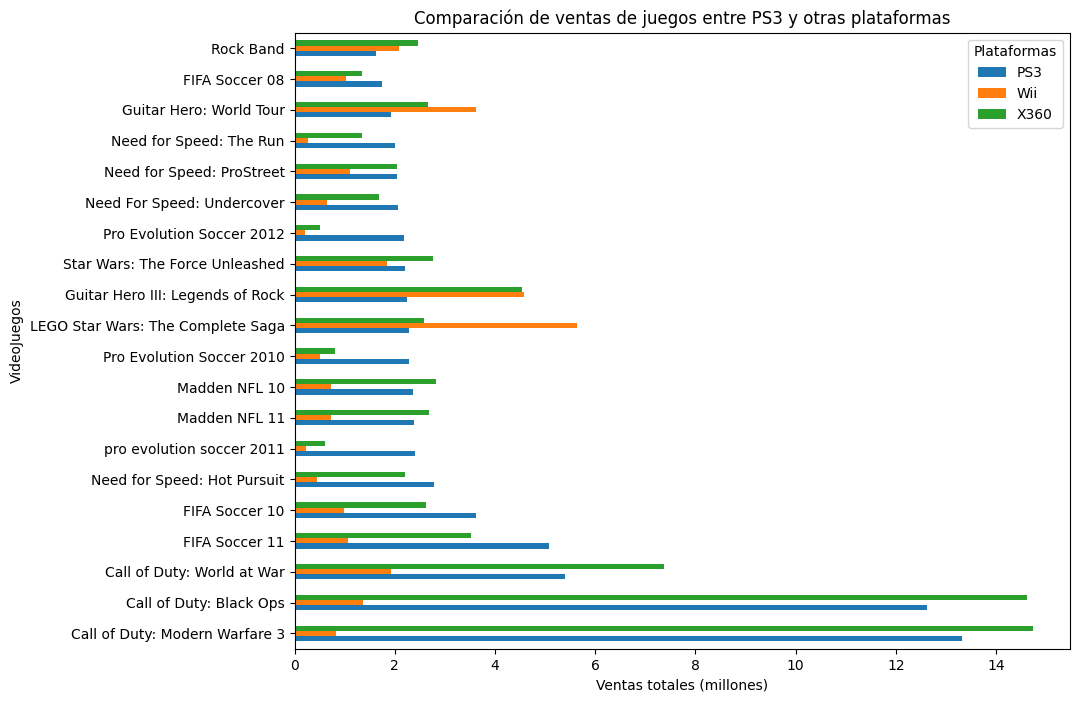

In [41]:
# Visualización del gráfico de barras
sales_comparison.plot(kind='barh', figsize=(10, 8), stacked=False)
plt.title('Comparación de ventas de juegos entre PS3 y otras plataformas')
plt.legend(title= 'Plataformas')
plt.xlabel('Ventas totales (millones)')
plt.ylabel('VideoJuegos')
plt.show()

#### Observaciones 
Las consolas PS3 y Xbox 360 tienen muchas más ventas que la Wii en los videojuegos más vendidos. Aunque la Wii parece quedarse atrás en general, destaca con un mayor índice de ventas en juegos dirigidos a un público más amplio, como el clásico Guitar Hero III: Legends of Rock.

Es posible que el éxito de la PS3 y la Xbox 360 se deba a su mayor potencia en cuanto a procesamiento gráfico, lo que resultaba muy atractivo para los usuarios interesados en juegos con gráficos avanzados. Por su parte, la Wii sobresalía por su innovación en el modo de juego, donde los controles capturaban el movimiento del jugador, lo que hacía que los juegos más didácticos o de simulación de realidad virtual fueran especialmente atractivos en esta consola.

También se puede observar que los jugadores de Call of Duty se inclinan más por la Xbox 360. Esto podría deberse a acuerdos de exclusividad temporal en contenido descargable que Microsoft tenía con Activision, el editor de Call of Duty.

Por su parte, la PS3 cuenta con ventas más altas en los juegos de FIFA en comparación con las otras consolas. Esto podría estar relacionado con la popularidad global del fútbol, especialmente en regiones donde la PS3 era la consola dominante.

#### Conclusion
Los acuerdos de exclusividad, así como la capacidad de ofrecer una mejor experiencia gráfica, son puntos clave en las estrategias de marketing de estas consolas. Sin embargo, también es importante ofrecer algo diferente o adicional, como lo hizo la Wii con su innovador sistema de juego. Al final, la elección de plataforma por parte de los usuarios depende de sus preferencias personales y de lo que buscan en una consola.

### Distribución general de los juegos por género.

In [42]:
# Agrupar los datos de genero y el las ventas totales
genre_sales = games_year_filtered[['genre','total_sales']]

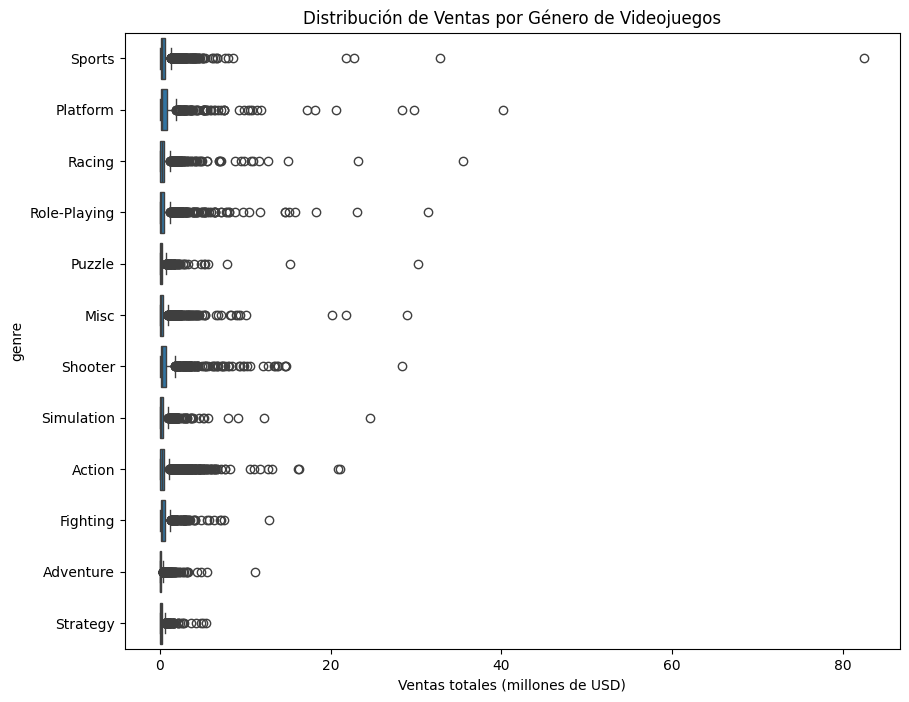

In [43]:
# Crea un grafico de caja para ver la dispersion de los datos
plt.figure(figsize=(10, 8))
sns.boxplot(y='genre', x='total_sales', data=genre_sales)
plt.title('Distribución de Ventas por Género de Videojuegos')
plt.xlabel('Ventas totales (millones de USD)')
plt.show()

#### Observaciones
La mayoría de las ventas en todas las categorías de géneros de videojuegos se concentran por debajo de los 20 millones de dólares. En ese rango, las ventas están muy concentradas cerca de 0, lo que indica que muchos juegos no alcanzan un volumen de ventas significativo. Sin embargo, en casi todos los géneros hay valores atípicos que se destacan significativamente.

Estos valores atípicos, que representan juegos con ventas mucho más altas que el promedio dentro de su género, sugieren que la diferencia en las ventas totales entre géneros no se debe necesariamente al género en sí, sino a la existencia de algunos juegos particularmente exitosos en cada categoría. Por ejemplo, un género podría parecer muy rentable en general, pero esto podría estar impulsado por uno o dos títulos excepcionales, mientras que la mayoría de los juegos dentro de ese género venden mucho menos.

#### Conclusion
No es posible generalizar que un género en particular siempre tendrá ventas altas o bajas. En cambio, parece que ciertos juegos dentro de un género pueden dominar las ventas, distorsionando la percepción de la rentabilidad del género en su conjunto. Esto también sugiere que el éxito en la industria de los videojuegos puede depender en gran medida de unos pocos títulos "superventas" dentro de cada categoría.

## Crear  un perfil de usuario para cada región
### Las cinco plataformas principales

In [44]:
# Crear un DF con las cinco plataformas principales en Europa.
eu_platform_sales = games_df.groupby('platform')['eu_sales'].sum()
top_eu_platform_sales = eu_platform_sales.sort_values(ascending=False).head()
top_eu_platform_sales

platform
PS2     339.29
PS3     330.29
X360    270.76
Wii     262.21
PS      213.61
Name: eu_sales, dtype: float64

In [45]:
# Crea un DF con las cinco plataformas principales en Japon.
jp_platform_sales = games_df.groupby('platform')['jp_sales'].sum()
top_jp_platform_sales = jp_platform_sales.sort_values(ascending=False).head()
top_jp_platform_sales

platform
DS      175.57
PS      139.82
PS2     139.20
SNES    116.55
3DS     100.67
Name: jp_sales, dtype: float64

In [46]:
# Crea un DF con las cinco plataformas principales en Norteamerica.
na_platform_sales = games_df.groupby('platform')['na_sales'].sum()
top_na_platform_sales = na_platform_sales.sort_values(ascending=False).head()
top_na_platform_sales

platform
X360    602.47
PS2     583.84
Wii     496.90
PS3     393.49
DS      382.40
Name: na_sales, dtype: float64

In [47]:
# Concatenar los dataframes resultantes para ver los top 5 en cada region
top_regions_platform_sales = pd.concat([top_eu_platform_sales, top_na_platform_sales, top_jp_platform_sales], axis=1)

In [48]:
# Obtener las plataformas más populares en todas las regiones
top_platforms = list(top_regions_platform_sales.index)

In [49]:
# Obtiene un DF filtrado con las ventas por region de las plataformas más populares 
region_platform_sales = pd.concat([eu_platform_sales, jp_platform_sales, na_platform_sales], axis=1)
region_platform_sales = region_platform_sales[region_platform_sales.index.isin(top_platforms)] 
region_platform_sales = region_platform_sales.sort_values('na_sales', ascending= False)

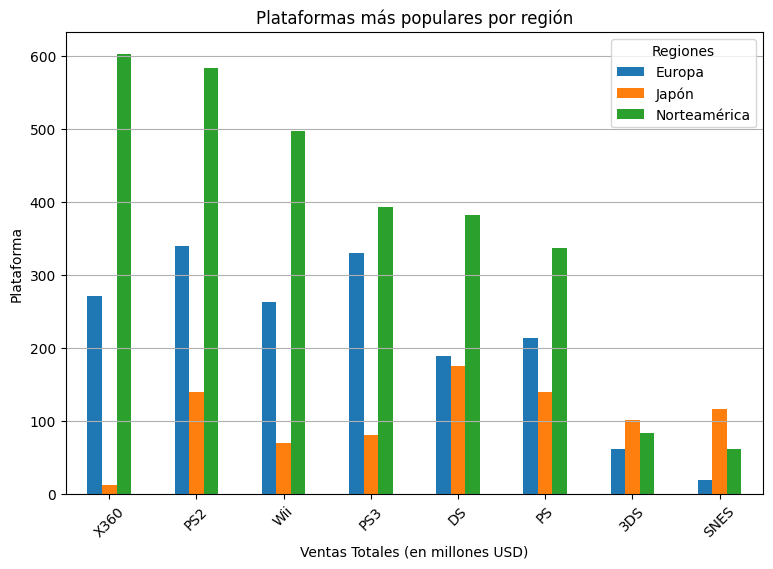

In [50]:
# Obtiene un DF filtrado con las ventas por region de las plataformas más populares 
region_platform_sales = pd.concat([eu_platform_sales, jp_platform_sales, na_platform_sales], axis=1)
region_platform_sales = region_platform_sales[region_platform_sales.index.isin(top_platforms)] 
region_platform_sales = region_platform_sales.sort_values('na_sales', ascending= False)
region_platform_sales.plot(kind='bar' ,figsize=(9, 6))
plt.title('Plataformas más populares por región')
plt.xticks(rotation=45) 
plt.xlabel('Ventas Totales (en millones USD)')
plt.legend(['Europa', 'Japón', 'Norteamérica'] ,title='Regiones')
plt.ylabel('Plataforma')
plt.grid(axis= 'y')
plt.show()

#### Observaciones
Plataformas Principales por Región:

Europa: Las plataformas más populares en Europa son la PS2, PS3, Xbox 360, Wii y PlayStation (PS1).

Norteamérica: En Norteamérica, la Xbox 360 es la plataforma líder, seguida por la PS2, Wii, PS3, y la Nintendo DS.

Japón: Japón muestra una clara preferencia por las plataformas de Nintendo, con Nintendo DS liderando las ventas, seguida de PlayStation, PS2, Super Nintendo (SNES), y Nintendo 3DS.

Xbox 360 es extremadamente popular en Norteamérica, liderando las ventas, mientras que en Japón ni siquiera aparece en el top 5. Esto puede deberse a la preferencia cultural por las consolas nacionales en Japón, donde las consolas de Nintendo y Sony dominan.

PS2 es una de las plataformas más consistentes, con altas ventas en todas las regiones. Esto refleja su éxito global y la extensa biblioteca de juegos que atrajo a una amplia audiencia.

Wii también es popular en Norteamérica y Europa, pero no aparece en el top 5 de Japón. Esto podría estar relacionado con las preferencias culturales y el tipo de juegos que tienen mayor éxito en Japón.

El análisis muestra que Norteamérica tiene el mercado más grande en términos de ventas, seguido por Europa y luego Japón. 
Aunque Japón es la cuna de muchas consolas, su mercado interno es más pequeño en comparación con Europa y Norteamérica, lo que podría explicar las menores ventas totales.

El hecho de que Japón registre menos ventas, a pesar de ser hogar de grandes empresas como Sony y Nintendo, tambien podria estar relacionado con una diferencia en la cultura del consumo de videojuegos. Mientras que Norteamérica y Europa tienen mercados más grandes y consumen más videojuegos, Japón podría estar más enfocado en el desarrollo y la innovación dentro de la industria.

Las diferencias en ventas entre estas regiones pueden estar influenciadas por factores económicos, demográficos y culturales.
Tomando en cuenta que las 3 regiones son de tamaños no proporcionales, Japón es un solo país, Europa es un continente, y No se especifica si Norteamerica se refiere al emisferio norte del continente Americano o al país de Estados Unidos.
#### Conclusion
Los datos no permiten establecer con seguridad si Japón genera menores ventas en videojuegos en comparación con otras regiones, debido a la falta de proporcionalidad en el tamaño de las regiones comparadas. Lo mismo ocurre entre Europa y Norteamérica. Sin embargo, se puede concluir que las preferencias por las consolas más vendidas difieren entre Japón, Norteamérica y Europa, lo que posiblemente se deba a las diferencias en los tipos de juegos que son más populares en cada una de estas regiones.

In [51]:
# Crea un DF con los cinco generos principales en Europa.
eu_genre_sales = games_df.groupby('genre')['eu_sales'].sum()
top_eu_genre_sales = eu_genre_sales.sort_values(ascending=False).head()
top_eu_genre_sales

genre
Action     519.13
Sports     376.79
Shooter    317.34
Racing     236.51
Misc       212.74
Name: eu_sales, dtype: float64

In [52]:
# Crea un DF con los cinco generos principales en Japon.
jp_genre_sales = games_df.groupby('genre')['jp_sales'].sum()
top_jp_genre_sales = jp_genre_sales.sort_values(ascending=False).head()
top_jp_genre_sales

genre
Role-Playing    355.41
Action          161.43
Sports          135.54
Platform        130.83
Misc            108.11
Name: jp_sales, dtype: float64

In [53]:
# Crea un DF con las cinco generos principales en Norteamerica.
na_genre_sales = games_df.groupby('genre')['na_sales'].sum()
top_na_genre_sales = na_genre_sales.sort_values(ascending=False).head()
top_na_genre_sales

genre
Action      879.01
Sports      684.43
Shooter     592.24
Platform    445.50
Misc        407.27
Name: na_sales, dtype: float64

In [54]:
# Concatenar los dataframes generos para ver los top 5 en cada region
top_region_genre_sales = pd.concat([top_eu_genre_sales, top_jp_genre_sales, top_na_genre_sales], axis=1)

In [55]:
# Obtener las plataformas más populares en todas las regiones
top_genres = list(top_region_genre_sales.index)

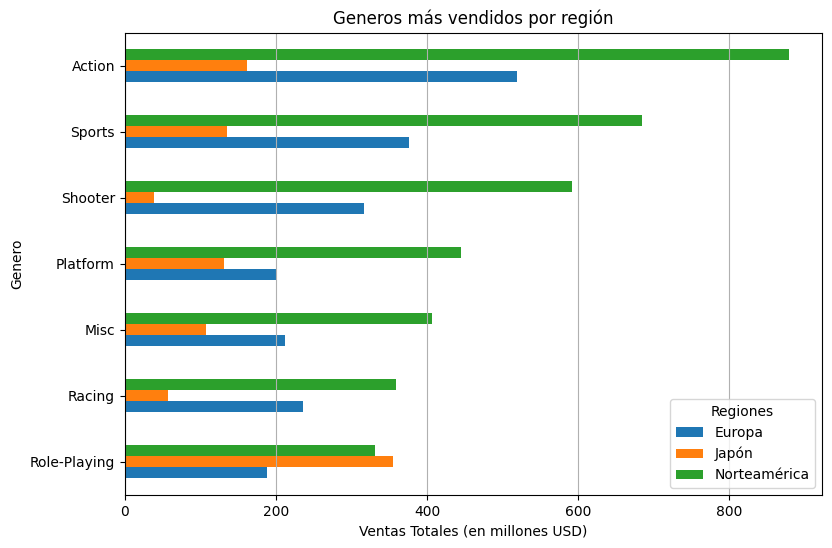

In [56]:
# Obtiene un DF filtrado con las ventas por region de las plataformas más populares 
region_genre_sales = pd.concat([eu_genre_sales, jp_genre_sales, na_genre_sales], axis=1)
region_genre_sales = region_genre_sales[region_genre_sales.index.isin(top_genres)] 
region_genre_sales = region_genre_sales.sort_values('na_sales', ascending= True)
region_genre_sales.plot(kind='barh', figsize=(9, 6))
plt.title('Generos más vendidos por región')
plt.xlabel('Ventas Totales (en millones USD)')
plt.legend(['Europa', 'Japón', 'Norteamérica'] ,title='Regiones')
plt.ylabel('Genero')
plt.grid(axis= 'x')
plt.show()

#### Observaciones:
Los géneros de videojuegos más populares son similares en las distintas regiones, con solo algunas variaciones. En general, los géneros de Acción, Deportes, Shooter (disparos) y Música están entre los más vendidos en Europa, Norteamérica y Japón. Sin embargo, hay algunas diferencias notables: en Japón, los juegos de rol ocupan el primer lugar, mientras que los juegos de disparos no están entre los más jugados. En contraste, los géneros de Carreras y Plataformas tienen mayor popularidad en Europa y Norteamérica, respectivamente.
Los Juegos de accion tienen casi el doble de ventas que los de musica a nivel global, es el genero más popular con casi 200 millones de diferencia con la categoria Sports.
#### Conclusion
En resumen, aunque las preferencias por géneros de videojuegos muestran consistencias entre las regiones, también reflejan las diferencias culturales que influyen en las elecciones de los jugadores. Géneros como Acción, Deportes y Shooter destacan por su alta popularidad global, lo que sugiere que estos tipos de juegos tienen un atractivo universal.

### ¿Las clasificaciones de ESRB afectan a las ventas en regiones individuales?

La Entertainment Software Rating Board o ESRB (Tablón de Clasificación del Software de Entretenimiento en español) es una organización que aplica clasificaciones a los videojuegos en América. Empezó en 1994. Las clasificaciones de la ESRB se basan en material gráfico, lenguaje, referencias al alcohol, violencia, y cosas por el estilo. Algunos contenidos descriptorios se encuentran abajo. Pocos juegos consiguen el rango de Niños pequeños o Adultos únicamente a menos de que estén hechos para dicha audiencia.

In [57]:
# Mostrar las clasificaciones presentes en el dataset
games_filtered_rating['rating'].unique()

array(['E', 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'], dtype=object)

#### Clasificaciones de ESRB

| **Clasificación** | **Descripción** | **Contenido Típico** |
|-------------------|------------------|-----------------------|
| **EC (Early Childhood)** | **Para edades tempranas** | Contenidos apropiados para niños pequeños. Sin violencia ni contenido inapropiado. |
| **E (Everyone)** | **Para todos** | Juegos adecuados para todas las edades. Pueden contener temas suaves, lenguaje leve o minimalista. |
| **E10+ (Everyone 10 and older)** | **Para mayores de 10 años** | Contenidos que pueden incluir violencia ligera o temas que podrían ser inquietantes para los menores. |
| **T (Teen)** | **Para adolescentes** | Contenidos que pueden incluir violencia más intensa, sugerencias sexuales, lenguaje fuerte o temas más maduros. |
| **M (Mature)** | **Para mayores de 17 años** | Contenidos que pueden incluir violencia intensa, lenguaje fuerte, temas sexuales explícitos o uso de drogas. |
| **AO (Adults Only)** | **Solo para adultos** | Contenidos extremadamente maduros que pueden incluir violencia gráfica, sexo explícito o uso de drogas sin restricciones. |
| **RP (Rating Pending)** | **Clasificación pendiente** | Juegos que aún no han sido clasificados y están esperando la evaluación de ESRB. |

#### Símbolos de Clasificación

- **EC (Early Childhood)**: A menudo representado por un símbolo de una cara de niño.
- **E (Everyone)**: Un símbolo de una cara de adulto sonriente.
- **E10+ (Everyone 10 and older)**: Una estrella con el número 10+.
- **T (Teen)**: Un símbolo de una cara de adolescente.
- **M (Mature)**: Un símbolo de una cara de adulto con el texto "Mature".
- **AO (Adults Only)**: Un símbolo que muestra una advertencia de "Adults Only".
- **RP (Rating Pending)**: Un símbolo de reloj de arena o un signo de interrogación que indica que la clasificación está en proceso.


In [58]:
# Crea un DF con las cinco clasificaciones mas vendidas en  Europa.
eu_rating_sales = games_filtered_rating.groupby('rating')['eu_sales'].sum()
top_eu_rating_sales = eu_rating_sales.sort_values(ascending=False).head()
top_eu_rating_sales

rating
E       710.25
M       483.97
T       427.03
E10+    188.52
AO        0.61
Name: eu_sales, dtype: float64

In [59]:
# Crea un DF con las cinco clasificaciones mas vendidas en  Japón.
jp_rating_sales = games_filtered_rating.groupby('rating')['jp_sales'].sum()
top_jp_rating_sales = jp_rating_sales.sort_values(ascending=False).head()
top_jp_rating_sales

rating
E       198.11
T       151.40
M        64.24
E10+     40.20
K-A       1.46
Name: jp_sales, dtype: float64

In [60]:
# Crea un DF con las cinco clasificaciones mas vendidas en Norteamérica.
na_rating_sales = games_filtered_rating.groupby('rating')['na_sales'].sum()
top_na_rating_sales = na_rating_sales.sort_values(ascending=False).head()
top_na_rating_sales

rating
E       1292.99
T        759.75
M        748.48
E10+     353.32
K-A        2.56
Name: na_sales, dtype: float64

In [61]:
# Concatenar los dataframes de rating para ver los top 5 en cada region
top_region_rating_sales = pd.concat([top_eu_rating_sales, top_jp_rating_sales, top_na_rating_sales], axis=1)

In [62]:
# Obtener las clasificaciones más populares en todas las regiones
top_ratings = list(top_region_rating_sales.index)

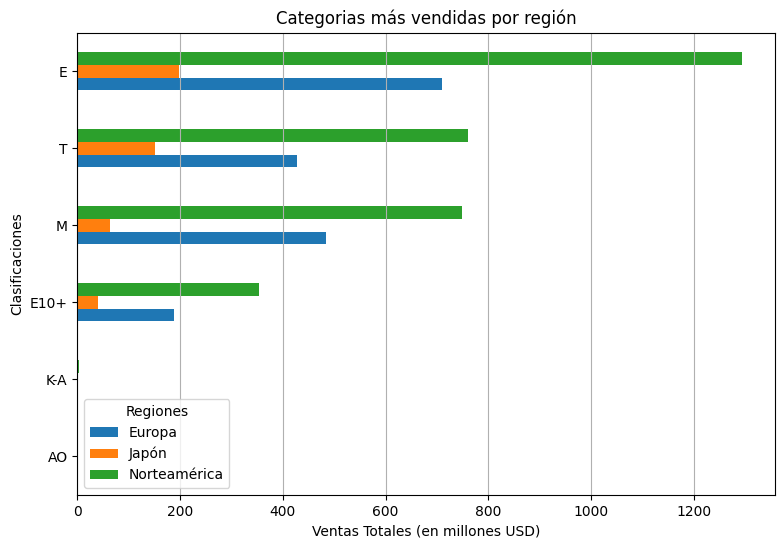

In [63]:
# Obtiene un DF filtrado con las ventas por region de las clasificaciones más populares 
region_ratings_sales = pd.concat([eu_rating_sales, jp_rating_sales, na_rating_sales], axis=1)
region_ratings_sales = region_ratings_sales[region_ratings_sales.index.isin(top_ratings)] 
region_ratings_sales = region_ratings_sales.sort_values('na_sales', ascending= True)
region_ratings_sales.plot(kind='barh', figsize=(9, 6))
plt.title('Categorias más vendidas por región')
plt.xlabel('Ventas Totales (en millones USD)')
plt.legend(['Europa', 'Japón', 'Norteamérica'] ,title='Regiones')
plt.ylabel('Clasificaciones')
plt.grid(axis= 'x')
plt.show()

#### Observaciones
La categoría más vendida a nivel global es **E** (Everyone), con un volumen de ventas que supera con creces a las demás clasificaciones. A esta la siguen los juegos clasificados como **T** (Teen), que ocupan el segundo lugar en Japón y Norteamérica, pero caen al tercer puesto en Europa, donde los juegos **M** (Mature) se venden más. Las ventas de los juegos con clasificación **M** son muy similares a las de la categoría **T**, pero significativamente mayores que las de **E10+** (Everyone 10+), la cual tiene aproximadamente 200 millones de dólares menos en ventas en cada región.

Por otro lado, las categorías **K-A** (Kids to Adults) y **AO** (Adults Only) tienen ventas casi nulas en comparación con las demás, lo que resalta la poca popularidad de los juegos más restrictivos en términos de edad.

#### Conclusiones.
La explicación de las diferencias en ventas es sencilla: mientras más amplia sea la audiencia que puede jugar un juego según su clasificación, mayores serán las ventas. Los juegos clasificados como **E**, que están dirigidos a todo tipo de público, son los que dominan en ventas. En cambio, los juegos con restricciones más severas, como los **AO**, apenas registran ventas.

Otro aspecto a tener en cuenta es que las clasificaciones **K-A** y **EC** (Early Childhood) fueron eliminadas y fusionadas en la categoría E en 1998 y 2014, respectivamente, lo que puede haber influido en la baja presencia de ventas en estas categorías en los datos actuales.

A nivel regional, todas las áreas analizadas siguen un patrón de ventas similar por clasificación, con la excepción de Europa, donde la categoría **AO** tiene más ventas que en Norteamérica y Japón, regiones donde la clasificación **K-A** ocupa el quinto lugar en la lista de ventas.



## Prueba las hipótesis estadísticas
### Primera hipótesis (Xbox One vs PC)

**H0 (Hipótesis Nula):** Las calificaciones promedio de los usuarios para las plataformas Xbox One y PC son iguales.

**H1 (Hipótesis Alternativa):** Las calificaciones promedio de los usuarios para las plataformas Xbox One y PC son diferentes.

In [64]:
# Filtra los datos de las calificaciones para las plataformas Xbox One y PC por separado
user_score_xone = filtered_df[(filtered_df['platform']=='XOne')]['user_score']
user_score_pc = filtered_df[(filtered_df['platform']=='PC')]['user_score']

In [65]:
# establece un nivel crítico de significación estadística
alpha = 0.05
# Calcula y muestra la varianza de las poblaciones para determinar si equal_var es True o False
print('var Xbox One:',np.var(user_score_xone),'\nvar PC:',np.var(user_score_pc))
# Prueba la hipótesis de que las medias de las dos poblaciones independientes son iguales
results = st.ttest_ind(user_score_xone, user_score_pc, equal_var=False)
# Imprime el valor p obtenido
print('valor p:',results.pvalue,'\n')
# Compara los valores p obtenidos con el nivel de significación estadística
if (results.pvalue < alpha):
    print("Rechazamos la hipótesis nula. Son diferentes las calificaciones promedio para las plataformas Xbox One y PC")
else:
    print("No podemos rechazar la hipótesis nula. La calificasiones promedio de los usuarios son las mismas para PC y Xbox One")

var Xbox One: 1.7855118457300279 
var PC: 2.315651111169566
valor p: 3.462578002314619e-05 

Rechazamos la hipótesis nula. Son diferentes las calificaciones promedio para las plataformas Xbox One y PC


### Segunda hipótesis (Acción vs Deportes)

**H0 (Hipótesis Nula):** Las calificaciones promedio de los usuarios para los géneros Acción y Deportes son iguales.

**H1 (Hipótesis Alternativa):** Las calificaciones promedio de los usuarios para los géneros Acción y Deportes son diferentes.

In [66]:
# Filtra los datos de las calificaciones para las plataformas Xbox One y PC por separado
user_score_action = filtered_df[(filtered_df['genre']=='Action')]['user_score']
user_score_sports = filtered_df[(filtered_df['genre']=='Sports')]['user_score']

In [67]:
# Establece un nivel crítico de significación estadística
alpha = 0.05
# calcula y muestra la varianza de las poblaciones para determinar si equal_var es True o False
print('var Acción:',np.var(user_score_action),'\nvar Deportes:',np.var(user_score_sports))
# Prueba la hipótesis de que las medias de las dos poblaciones independientes son iguales
results = st.ttest_ind(user_score_action, user_score_sports, equal_var=False)
# Imprime el valor p obtenido
print('valor p:',results.pvalue,'\n')
# Compara los valores p obtenidos con el nivel de significación estadística
if (results.pvalue < alpha):
    print("Rechazamos la hipótesis nula.\n",
          "Existe una clara diferencia entre el promedio de las clificaciones de los usuarios para los generos de Accion y Deportivos")
else:
    print("No podemos rechazar la hipótesis nula.\n","La diferencia entre el promedio de las calificaciondes de los generos de Acción y Deportivo no es muy significativa")

var Acción: 1.9490243851270599 
var Deportes: 2.105018660349879
valor p: 0.8206115102416659 

No podemos rechazar la hipótesis nula.
 La diferencia entre el promedio de las calificaciondes de los generos de Acción y Deportivo no es muy significativa


### Conclusiones
Las hipotesis nulas siempre se basan en que no hay diferencia entre las poblaciones de datos que se comparan, y la hipotesis alternativa siempre asume lo contrario a la nula, es decir que existe alguna diferencia significativa entre ambos conjuntos de datos.

Para ambos análisis se utilizó el testt para muestras independientes, ya que los conjuntos no estaban directamente relacionados y como se puede observar las varianzas no son iguales en ninguno de los dos casos.

## Conclusiones generales
Las ventas de videojuegos están influenciadas por diversos factores, como la demografía, los cambios culturales y el avance de las tecnologías. A nivel histórico, la consola con mayores ventas ha sido la PlayStation 2, que probablemente impulsó significativamente el mercado desde la década de 2000.

Con el tiempo, surgió más competencia debido a la rentabilidad del mercado. Consolas como la Wii, Xbox 360 y PS3 aprovecharon este auge, aunque las ventas comenzaron a decrecer alrededor de 2010 tras alcanzar su punto máximo.

Los videojuegos con clasificación E (para todos los públicos) son los más populares a nivel global. Los géneros más vendidos en esta categoría incluyen Acción, Deportes, Plataformas y Musical. En contraste, los juegos con clasificaciones más restrictivas generan menos ventas.

Aunque la popularidad de las consolas varía ligeramente entre regiones, las distintas plataformas de PlayStation y Nintendo han mantenido una base de seguidores sólida a lo largo del tiempo. Por su parte, Xbox, aunque popular, parece tener un público objetivo principalmente en Norteamérica, donde genera la mayoría de sus ventas.

Una posible explicación para las altas ventas de Microsoft en Norteamérica es la popularidad de los juegos de disparos (Shooters), un género que no es tan popular en Japón, lo que podría explicar el menor éxito de las plataformas de Microsoft en esa región.

Los generos de los juegos no tienen gran relevancia en su exito de ventas, depende más del total del videojuego que del genero de este.
Un factor con relevancia relativa es la puntuacion de los usuarios y los criticos, aunque estas tienen una pequeña correlacion entre las ventas totales de los videojuegos no son determinantes,
Ya que el mercado de videojuegos actualmente es tan amplio es conveniente lanzar los videojuegos con compatibilidad con mas de una de ellas a menos que el proposito sea impulsar la compra de una de estas con la el lanzamiento del videojuego